First, we declare the path to the input dataset (datasets/original). A Breast Cancer Histology Image Dataset from kaggle: https://www.kaggle.com/paultimothymooney/breast-histopathology-images/source 

In [12]:
import os 
os.chdir('C:\\Users\\abebu\\Dropbox\\Data Science\\DeepLearning\\Capstone Project 2\\breast-cancer-classification')
mkdir datasets\original

After we copy the downloaded dataset to the datasets/origianl folder, we declare the path for the new directory (datasets/idc), and the paths for the training, validation, and testing directories using the base path. 

In [13]:
EPOCHS = 40
BS = 32
LEARNING_RATE = 1e-2
INPUT_DATASET = 'datasets\original'
BASE_PATH = 'datasets/idc'
TRAIN_PATH = os.path.sep.join([BASE_PATH, 'training'])
VAL_PATH = os.path.sep.join([BASE_PATH, 'validation'])
TEST_PATH = os.path.sep.join([BASE_PATH, 'testing'])

We also declare that 80% of the entire dataset will be used for training, and of that, 10% will be used for validation.

In [14]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

Next, we’ll import from config, imutils, random, shutil, and os. `config` settings and `paths` to build a list of original paths to the images, then we use `random` to randomly shuffle our paths, `shutil` to copy images, and `os` for joining paths and making directories (*Lines 1-3*)

Then we will grab all the `originalPaths` for our dataset and randomly suffle them (*Lines 5-7*). 

Then, we calculate an `index` by multiplying the length of this list by 0.8 so we can slice this list to get sublists for the training and testing datasets (*Lines 9-11*). Next, we further calculate an index saving 10% of the list for the training dataset for validation (`valPaths`)(*Line 14*) and keeping the rest for training itself (`trainPaths`) (*Line 15*).

*Lines 17-20* defines a list with tuples called `datasets`. Inside are three tuples, each with the information required to organize all of our `originalPaths` into training, validation, and testing sets. These hold the paths and the base path for each. 

In [15]:
from cancernet import config
from imutils import paths
import random, shutil

originalPaths=list(paths.list_images(config.INPUT_DATASET))
random.seed(7)
random.shuffle(originalPaths)

index=int(len(originalPaths)*config.TRAIN_SPLIT)
trainPaths=originalPaths[:index]
testPaths=originalPaths[index:]

index=int(len(trainPaths)*config.VAL_SPLIT)
valPaths=trainPaths[:index]
trainPaths=trainPaths[index:]

datasets= [('training', trainPaths, config.TRAIN_PATH),
          ('validation', valPaths, config.VAL_PATH),
          ('testing', testPaths, config.TEST_PATH)
]


## Preparing idc Datasets in PyTorch 

Load image data using `datasets.ImageFolder` from `torchvision`
I import `matplotlib.pyplot` as `plt` where matplotlib is a 2D Plotting library for displaying image as well as I import `torch` and `datasets` and `transforms` from `torchvision` and `helper` module.


`Transform` using `ImageFolder` as
dataset = datasets.ImageFolder('path', transform=transform)
where ‘path’ is the path to the data set which the path to the folder where the data is present and while loading data with ImageFolder we need to define some transforms because images are of different sizes and shape and we need all image in training set to be of the same size for training. Therefore we define resize with transform.Resize() or crop with transforms.CenterCrop(), transforms.RandomResizedCrop() also we need to convert all the image to PyTorch tensors for this purpose we use transforms.ToTensor(). Also, we will combine this transforms to pipeline with transforms.Compose(), which run the list of transforms in sequence.

`Data Loaders`
After loaded ImageFolder, we have to pass it to DataLoader. It takes a dataset and returns batches of images and corresponding labels. Here we can set batch_size and shuffle (True/False) after each epoch. For this we need to pass dataset, batch_size, shuffle into torch.utils.data.DataLoader()

`Testing Data Loader`
Here, data loader is a generator and to get data out of it, we need to loop through it or convert it to an iterator and call next()



Next, we loop over the `datasets` list.

For each `setType`, `originalPaths`, and `basePath` in this list, we’ll print, say, ‘Building testing set’. If the base path does not exist, we’ll create the base output directory (*Lines 1-6*).  

And for each path in `originalPaths`, we'll implement a nested loop over all input images in the current split (*Line 8*), we’ll extract the `file` name from the input path (*Line 9*) and then extract the class `label` from the `file` (*Line 10*). We’ll build the output path (`labelPath`)to the label directory(0 or 1)- if it doesn’t exist yet, we’ll explicitly create this directory (*Lines 12-15*). Finally, we’ll build the path to the resulting image and copy the image into its destination- where it belongs (*Lines 17 and 19*). 


In [5]:
for (setType, originalPaths, basePath) in datasets:
    print(f'Building {setType} set')
    
    if not os.path.exists(basePath):
        print(f'Building directory {basePath}')
        os.makedirs(basePath)
        
    for path in originalPaths:
        file=path.split(os.path.sep)[-1]
        label=file[-5:-4]
        
        labelPath=os.path.sep.join([basePath, label])
        if not os.path.exists(labelPath):
            print(f'Building directory {labelPath}')
            os.makedirs(labelPath)
            
        newPath=os.path.sep.join([labelPath, file])
        shutil.copy2(path, newPath)

Building training set
Building directory datasets/idc\training
Building directory datasets/idc\training\0
Building directory datasets/idc\training\1
Building validation set
Building directory datasets/idc\validation
Building directory datasets/idc\validation\0
Building directory datasets/idc\validation\1
Building testing set
Building directory datasets/idc\testing
Building directory datasets/idc\testing\0
Building directory datasets/idc\testing\1


In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils.data as data 
import torchvision
from torchvision import datasets, transforms

In [30]:
# First i want to calculate mean and standard deviation of my training set
# to get the values for transforms.Normalize
transform_train = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

trainset = datasets.ImageFolder(TRAIN_PATH, transform=transform_train)

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = data.DataLoader(dataset, batch_size=BS, shuffle=True, num_workers=4)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std



In [31]:
get_mean_and_std(trainset)

==> Computing mean and std..


(tensor([0.0251, 0.0191, 0.0226]), tensor([0.0043, 0.0066, 0.0046]))

In [26]:
# Transform the data to torch tensors and normalize it 

transform_idc = transforms.Compose([transforms.Resize(255),
                                      transforms.ToTensor()])
                                    
# Prepare training set, validation set and testing set
trainset = datasets.ImageFolder(TRAIN_PATH, transform=transform_idc)
valset = datasets.ImageFolder(VAL_PATH, transform=transform_idc)
testset = datasets.ImageFolder(TEST_PATH, transform=transform_idc )

# Prepare training loader and testing loader (makes datasets iterable)

#parameters 
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}

trainloader = data.DataLoader(trainset, **params)
valloader = data.DataLoader(valset, **params)
testloader = data.DataLoader(testset, **params)

In [19]:
print(trainset,valset, testset)

Dataset ImageFolder
    Number of datapoints: 71899
    Root location: datasets/idc\training
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(50, 50), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-20, 20), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.0233, 0.0178, 0.021], std=[0.0076, 0.008, 0.0073])
           ) Dataset ImageFolder
    Number of datapoints: 7988
    Root location: datasets/idc\validation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(50, 50), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-20, 20), resample=False

## Dataset

In [24]:
print('There are {} images in the training set'.format(len(trainset)))
print('There are {} images in the validation set'.format(len(valset)))
print('There are {} images in the testing set'.format(len(testset)))
print('There are {} batches in the training loader'.format(len(trainloader)))
print('There are {} batches in the validation loader'.format(len(valloader)))
print('There are {} batches in the testing loader'.format(len(testloader)))

There are 71899 images in the training set
There are 7988 images in the validation set
There are 19972 images in the testing set
There are 2247 batches in the training loader
There are 250 batches in the validation loader
There are 625 batches in the testing loader


## Show a batch of images 

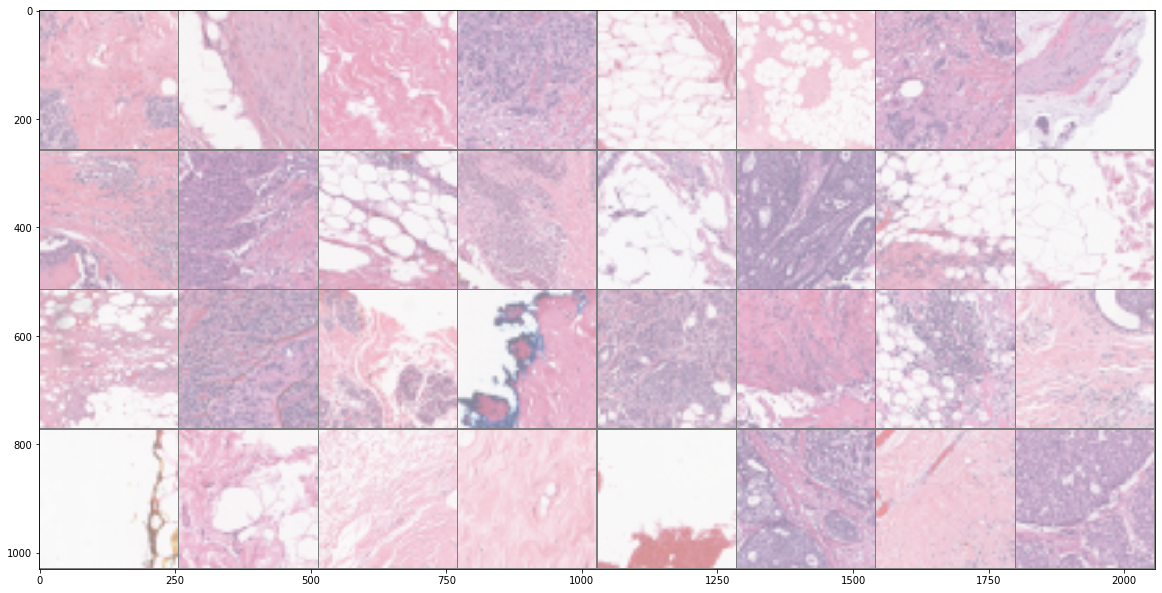

In [27]:
#Show a batch of images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))

In [33]:

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))

TypeError: iter() takes no keyword arguments